# Setup

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tslearn.metrics import cdist_dtw
import os
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

In [4]:
def load_data(tickers):
    stocks = pd.DataFrame()    
    for ticker in tickers:
        stock_data = yf.download(ticker, period = 'max')
        stock_data = stock_data[["Open", "High", "Low", "Close", "Volume"]]
        stock_data = stock_data.rename(columns=lambda x: ticker + "_" + x)
        stocks = stocks.join(stock_data, how = "outer")
    return stocks

In [9]:
def earliest_date_no_nan(df):
    df_no_nan = df.dropna(how='any')
    earliest_date = df_no_nan.index.min()
    return earliest_date

In [5]:
tickers = ["ABNB", "AMC", "GME","MULN","META","NVDA","TSLA","PTON","W"]

In [6]:
feature_names = ['High', 'Low', 'Open', 'Close', 'Volume']

# Load Data

In [7]:
df = load_data(tickers)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [10]:
earliest_date = earliest_date_no_nan(df)

In [11]:
df = df.loc["2018-01-01":"2024-08-16"]

In [12]:
df_close = df.filter(regex=r'\_Close$', axis=1)

# Visualizations

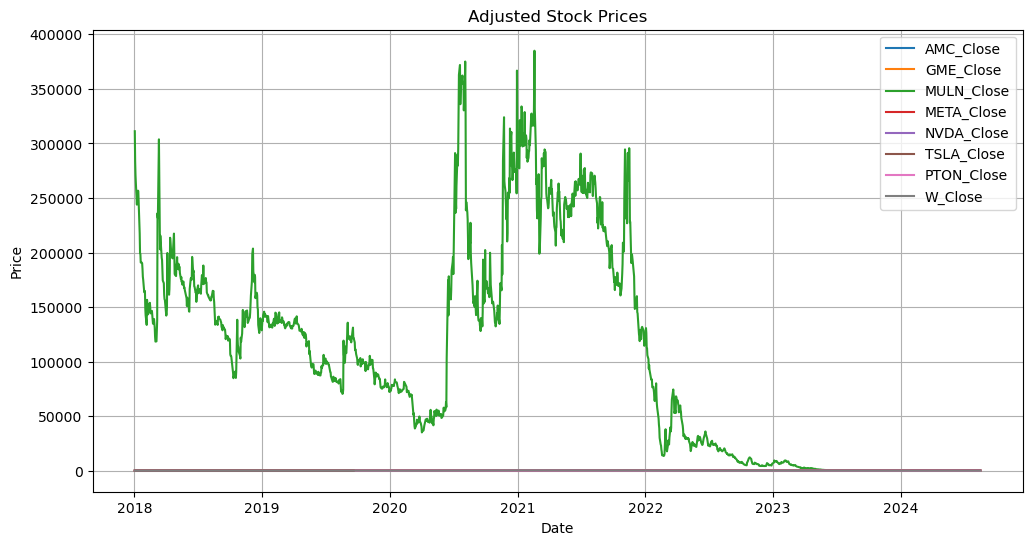

In [13]:
plt.figure(figsize=(12, 6))
for column in df_close.columns[1:len(df_close.columns)]:
    plt.plot(df_close.index, df_close[column], label=column)

plt.title('Adjusted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
#plt.savefig('multiple-timelines.png')
plt.show()

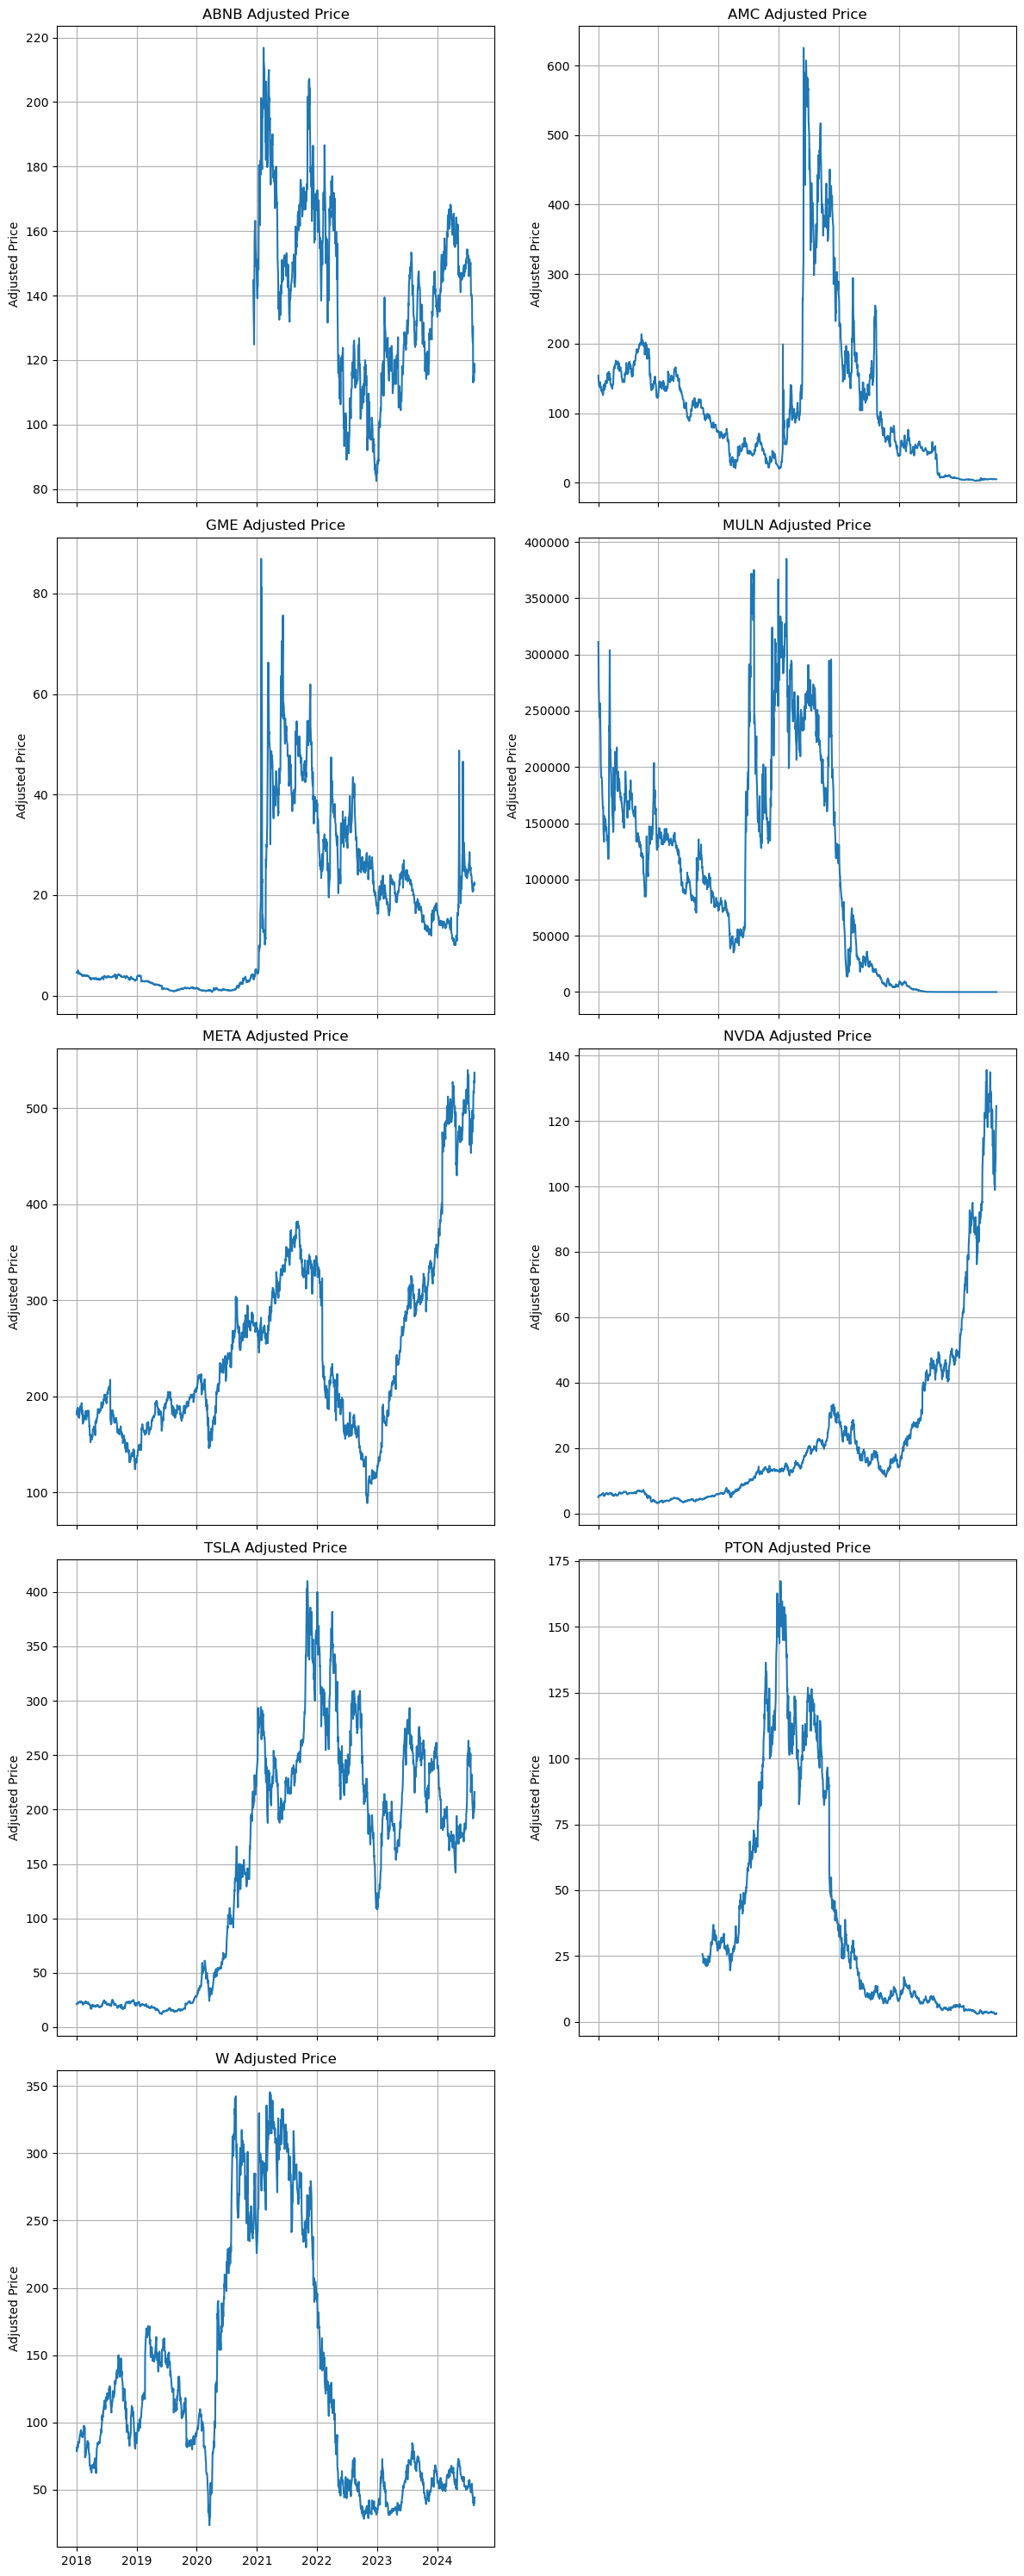

In [14]:
n_cols = 2
n_rows = (len(df_close.columns) + 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 6 * n_rows), sharex=True)
axes = axes.flatten()
for ax, column, ticker in zip(axes, df_close.columns, tickers):
    ax.plot(df_close.index, df[column], label=column)
    ax.set_title(f'{ticker} Adjusted Price')
    ax.set_ylabel('Adjusted Price')
    ax.grid(True)

for ax in axes[len(df_close.columns):]:
    ax.set_visible(False)
plt.tight_layout()
#plt.savefig("grid-timelines.png")
plt.show()

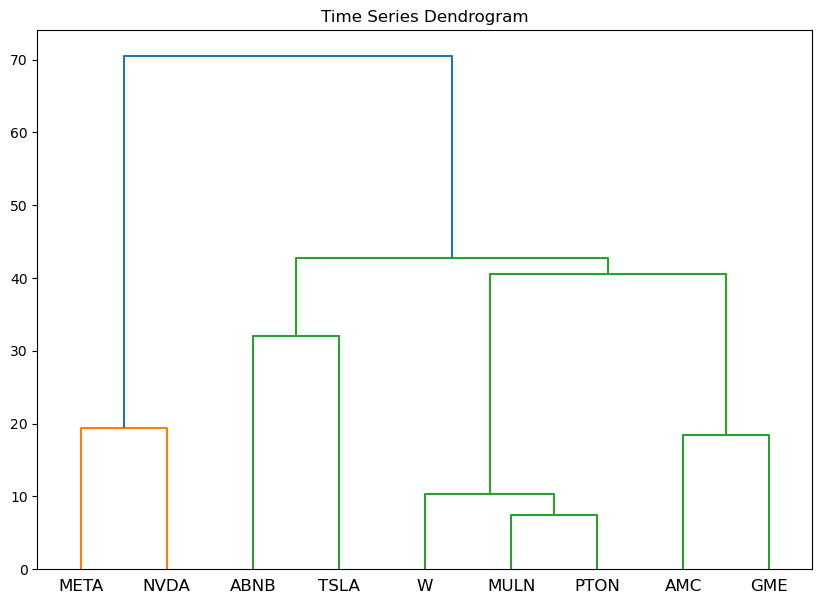

In [15]:
temp = df_close.dropna() # Multivariate clustering is also available, but we're just using close to keep things simple
time_series_data = []
for ticker in tickers:
    stock_data = temp[[f'{ticker}_Close']].values
    time_series_data.append(stock_data.T)
data = np.array(time_series_data).transpose(0, 2, 1)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.) # Most clustering methods require normalization
data_normalized = scaler.fit_transform(data).squeeze()
distance_matrix = pdist(data_normalized, metric='euclidean')
Z = linkage(distance_matrix, method='ward') # Different linkage methods and distance metrics can change the results
                                            # try a few and see what happens!
plt.figure(figsize=(10, 7))
plt.title("Time Series Dendrogram")
dendrogram(Z, labels=tickers)
#plt.savefig('dendrogram.png')
plt.show()